In [1]:
import numpy as np
from qibo.models import Circuit
from qibo import gates
from qibo import callbacks
import matplotlib.pyplot as plt
import time 

[Qibo 0.1.6|INFO|2022-02-22 16:08:34]: Using numpy backend on /CPU:0
[Qibo 0.1.6|WARNING|2022-02-22 16:08:34]: numpy backend uses `np.einsum` and supports CPU only. Consider installing the qibojit or qibotf backends for increased performance and to enable GPU acceleration.


### Oracle

In [2]:
def binary_to_decimal(binary_number):
    decimal_number = 0 

    for position, string_digit in enumerate(binary_number[::-1]):
        decimal_number += int(string_digit) * 2 ** position

    return decimal_number


In [3]:
def oracle_general(nqubits,state):
    
    inv_matrix = np.zeros( (2**nqubits, 2**nqubits) )

    for i in range(0,2**nqubits):
        for j in range(0,2**nqubits):
            if i == j:
                if i == state : 
                    inv_matrix[i][j] = -1 
                else:
                    inv_matrix[i][j] = 1 

    return c.add(gates.Unitary(inv_matrix,*range(0,nqubits)))
    

In [4]:
def MCZ(q0,nqubits): # defining multi-controlled Z function 
    c.add(gates.H(q0))
    c.add(gates.X(q0).controlled_by(*range(1,nqubits)))
    c.add(gates.H(q0))
    return c 

In [5]:
def difussion(q0,nqubits): 
    for i in range(0,nqubits):
        c.add(gates.H(i))
        
    for i in range(0,nqubits):
        c.add(gates.X(i))
        
    MCZ(q0,nqubits)
    
    for i in range(0,nqubits):
        c.add(gates.X(i))
        
    for i in range(0,nqubits):
        c.add(gates.H(i))
    return c

### Grover's algorithm 1 iteration

How many qubits does the circuit have? 3
Which state do you want to find? 3
2
q0: ─H─U─H─X─H─X─H─X─H─U─H─X─H─X─H─X─H─
q1: ─H─U─H─X───o─X─H───U─H─X───o─X─H───
q2: ─H─U─H─X───o─X─H───U─H─X───o─X─H───
---0.007674217224121094 seconds ---


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:825: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:687: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(textobj.convert_yunits(textobj._y))


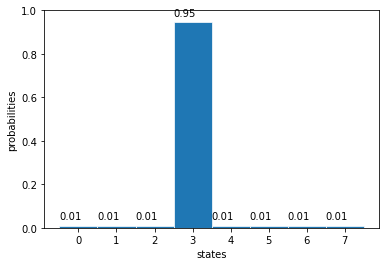

In [6]:
nqubits = int(input("How many qubits does the circuit have? "))
state = int(input("Which state do you want to find? "))

start_time = time.time()

c = Circuit(nqubits) # Construct the circuit (2 qubits)

for i in range(0,nqubits):
    c.add(gates.H(i)) # Add some gates

R = int((np.pi/4)*np.sqrt(2**nqubits))
print(R)

for i in range(0,R):
    # Rotation of the wanted state
    oracle_general(nqubits,state) 

    difussion(0,nqubits)
    

# Execute the circuit and obtain the final state
result = c() # c.execute(initial_state) also works
# Draw the circuit
print(c.draw())

x = range(2**nqubits) 

y = result.state(numpy=True)

print("---%s seconds ---" % (time.time()-start_time))

prob = [x*x.conjugate() for x in y] # elevating coeficients 

fig, ax = plt.subplots()

ax.bar(x, prob, width=1, edgecolor="white", linewidth=0.7)
ax.set(ylim=(0, 1), xlabel = 'states', ylabel = 'probabilities')

i=0 #writes the probability of each state 
for el in prob:
    ax.text(i-0.5,el+0.03, str(round(el.real, 2)), fontsize=10)
    i=i+1

plt.show()